In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Dropout,Flatten,Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


import os
import cv2

In [2]:
os.listdir('../input/histopathologic-cancer-detection')

['sample_submission.csv', 'train_labels.csv', 'test', 'train']

In [3]:
print(len(os.listdir('../input/histopathologic-cancer-detection/train')))

220025


In [4]:
print(len(os.listdir('../input/histopathologic-cancer-detection/test')))

57458


In [5]:
images_train=('../input/histopathologic-cancer-detection/train')
train_labels=pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

images_name = train_labels
images_name['label'] = images_name['label'].astype(str)
images_name['id'] = train_labels['id'] + '.tif'

images_test='../input/histopathologic-cancer-detection/test'

In [6]:
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [7]:
train_labels.describe()

,id,label
count,220025,220025
unique,220025,2
top,f38a6374c348f90b587e046aac6079959adf3835.tif,0
freq,1,130908


In [8]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  object
dtypes: object(2)
memory usage: 3.4+ MB


130908
89117
1.468945319074924


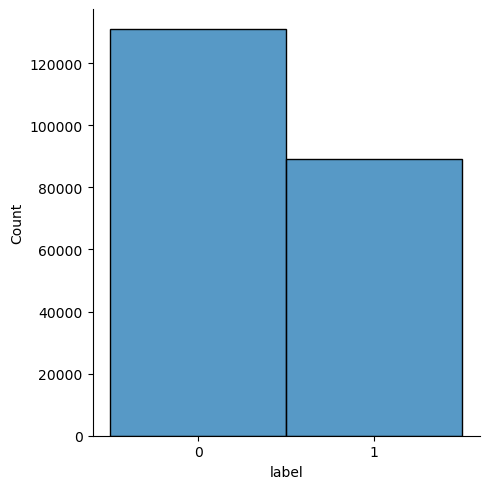

In [9]:
sns.displot(train_labels['label'])
label_counts=train_labels['label'].value_counts()
print(label_counts[0])
print(label_counts[1])
print(label_counts[0]/label_counts[1])

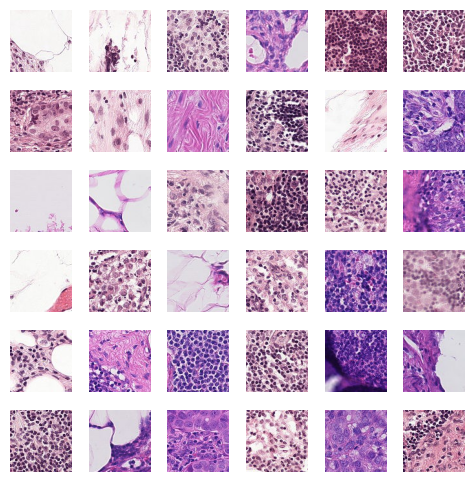

In [10]:
 #Examining the images
    
rows, cols = 6, 6

fig, axes = plt.subplots(rows, cols, figsize=(6, 6))

for i in range(6 * 6):
    image = plt.imread(images_train +'/' +images_name['id'][i])

    row, col = i // cols, i % cols

    axes[row, col].imshow(image)
    axes[row, col].axis('off')

plt.subplots_adjust(wspace = 0.1, hspace = 0.3)

plt.show()


In [11]:
#Initializing the CNN
cnn=Sequential()

In [12]:
#Adding first convolutional layer and pooling layer
cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu',input_shape=[64,64,3]))
cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))

In [13]:
#Adding pooling layer
cnn.add(MaxPooling2D(pool_size=2,strides=2))

In [14]:
#Adding the second convolutional layer
cnn.add(Conv2D(filters=32, kernel_size=3,activation='relu'))
cnn.add(Conv2D(filters=32, kernel_size=3,activation='relu'))

In [15]:
cnn.add(MaxPooling2D(pool_size=2,strides=2))

In [16]:
cnn.add(tf.keras.layers.Flatten())

In [17]:
#Full connection and Output layer
cnn.add(Dense(units=128, activation='relu'))
cnn.add(Dense(units=1, activation='sigmoid'))

In [18]:
#Compiling the cnn
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [19]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   validation_split=0.25,
                                   horizontal_flip = True)
training_set = train_datagen.flow_from_dataframe(
    dataframe = images_name,
    x_col='id', # filenames
    y_col='label', # labels
    directory=images_train,
    subset='training',
    class_mode='binary',
    batch_size=256,
    target_size=(64, 64))

Found 165019 validated image filenames belonging to 2 classes.


In [20]:
    data_validate=train_datagen.flow_from_dataframe(
    dataframe=images_name,
    x_col='id', # filenames
    y_col='label', # labels
    directory=images_train,
    subset="validation",
    class_mode='binary',
    batch_size=32,
    target_size=(64, 64))

Found 55006 validated image filenames belonging to 2 classes.


In [21]:
cnn.fit(x = training_set, validation_data = data_validate, epochs = 10)

Epoch 1/10
645/645 [==============================] - 1937s 3s/step - loss: 0.4483 - accuracy: 0.7928 - val_loss: 0.3988 - val_accuracy: 0.8225
Epoch 2/10
645/645 [==============================] - 1859s 3s/step - loss: 0.3765 - accuracy: 0.8350 - val_loss: 0.3499 - val_accuracy: 0.8482
Epoch 3/10
645/645 [==============================] - 1898s 3s/step - loss: 0.3400 - accuracy: 0.8528 - val_loss: 0.3399 - val_accuracy: 0.8540
Epoch 4/10
645/645 [==============================] - 1641s 3s/step - loss: 0.3174 - accuracy: 0.8636 - val_loss: 0.3021 - val_accuracy: 0.8747
Epoch 5/10
645/645 [==============================] - 1642s 3s/step - loss: 0.2974 - accuracy: 0.8746 - val_loss: 0.3032 - val_accuracy: 0.8707
Epoch 6/10
645/645 [==============================] - 1615s 3s/step - loss: 0.2774 - accuracy: 0.8842 - val_loss: 0.2913 - val_accuracy: 0.8766
Epoch 7/10
645/645 [==============================] - 1621s 3s/step - loss: 0.2634 - accuracy: 0.8905 - val_loss: 0.2677 - val_accuracy:

In [22]:
test_data = pd.DataFrame({'id':os.listdir(images_test)})

generator_test = ImageDataGenerator(rescale=1./255)

data_test = generator_test.flow_from_dataframe(
    dataframe = test_data,
    x_col='id', # filenames
    directory=images_test,
    class_mode=None,
    batch_size=1,
    target_size=(64, 64),
    shuffle=False)

Found 57458 validated image filenames.


In [23]:
predictions = cnn.predict(data_test, verbose=1)

57458/57458 [==============================] - 488s 8ms/step
